In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch_utils import *
from dataset import Dataset
from basicnet import Net
import matplotlib.pyplot as plt

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

params = {'benchmark': 'adult', 'maxlen': 0, 'batch_size': 500,
          'split': [0.7, 0.2, 0.1], 'seed': 2,
          'epochs': 100, 'lr': 0.001}
data = Dataset(params, 'train', device)

model = Net(data.nfeatures, [10,5])
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

/content/dataloader.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[y_feat][column] = classes[0]
/content/dataloader.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[y_feat][column] = classes[1]


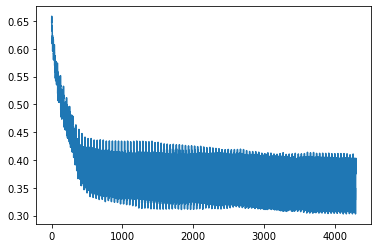

In [2]:
y_loss=[]
for epoch in range(params['epochs']):
    for (x, y) in data:
        (x, y) = x.to(device), y.to(device)
        optimizer.zero_grad()
        ŷ = model(x)
        loss = loss_fn(ŷ, y)
        y_loss.append(loss.item())
        loss.backward()
        optimizer.step()
plt.plot(y_loss)

In [33]:
ŷ.data.max(1, keepdim=True)[1].size()

torch.Size([113, 1])

In [34]:
data_test = Dataset(params, 'test', device)

/content/dataloader.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[y_feat][column] = classes[0]
/content/dataloader.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[y_feat][column] = classes[1]


In [37]:
test_size = 0
correct = 0
for (x, y) in data_test:
  (x, y) = x.to(device), y.to(device)
  ŷ = model(x)
  test_size += len(x)
  correct += ŷ.data.max(1, keepdim=True)[1].eq(y.view_as(ŷ.data.max(1, keepdim=True)[1])).sum().item()

accuracy = correct / test_size
print('This basicnet has ' + str(accuracy) + ' out of 1 in terms of accuracy')

This basicnet has 0.7395557029177718 out of 1 in terms of accuracy


In [3]:
from cache import Cache
cache = Cache(2) # we'll use only the hidden layers

for epoch in range(params['epochs']):
    for (x, y) in data:
        (x, y) = x.to(device), y.to(device)
        h2 = model.get_embedding(x, 1) 
        cache.store(h2, 1)

        h3 = model.get_embedding(x, 2) 
        cache.store(h3, 2)
        cache.store_label(y)

In [4]:
from autoencoder import AutoEncoder
ae1 = AutoEncoder(model._l_dim[1], 2)
ae2 = AutoEncoder(model._l_dim[2], 2)

ae_loss1 = nn.MSELoss()
ae_loss2 = nn.MSELoss()
opt1 = optim.Adam(ae1.parameters(), lr=0.001)
opt2 = optim.Adam(ae2.parameters(), lr=0.001)

y1_loss=[]
y2_loss=[]

for epoch in range(5):#params['epochs']):
    for x1 in cache.embeddings[1]:
        opt1.zero_grad()
        x̃1 = ae1(x1)
        l1 = ae_loss1(x̃1, x1)
        l1.backward(retain_graph=True)
        opt1.step() 
        y1_loss.append(l1.item())
    
    for x2 in cache.embeddings[2]:
        opt2.zero_grad()
        x̃2 = ae2(x2)
        l2 = ae_loss2(x̃2, x2)
        l2.backward(retain_graph=True)
        opt2.step()
        y2_loss.append(l2.item())

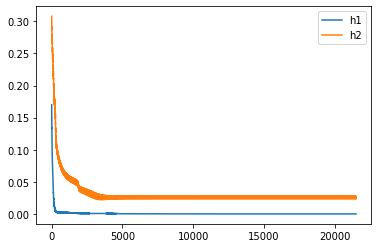

In [5]:
plt.plot(y1_loss)
plt.plot(y2_loss)
plt.legend(['h1', 'h2'])

In [6]:
'''This aims to split tensors so that batchsize will be equal to 1'''
from split import *
split_1 = []
split_1 = split(cache.embeddings[1], split_1)
split_2 = []
split_2 = split(cache.embeddings[2], split_2)
split_labels = []
split_labels = split(cache.labels, split_labels)

In [7]:
'''This aims to store the first and second element of the output tensor, in order to construct bins'''
a1 = []
b1 = []
a2 = []
b2 = []
each_label = []
for x in split_1:
  x_out1 = ae1.encode(x)
  a1.append(x_out1.detach().numpy()[0][0])
  b1.append(x_out1.detach().numpy()[0][1])

for x in split_2:
  x_out2 = ae2.encode(x)
  a2.append(x_out2.detach().numpy()[0][0])
  b2.append(x_out2.detach().numpy()[0][1])

for label in split_labels:
  each_label.append(label.numpy()[0][0])




In [8]:
import numpy as np
a1_0 = []
b1_0 = []
a2_0 = []
b2_0 = []
a1_1 = []
a2_1 = []
b1_1 = []
b2_1 = []
for i in range(len(each_label)):
  if each_label[i] == 0:
    a1_0.append(a1[i])
    b1_0.append(b1[i])
    a2_0.append(a2[i])
    b2_0.append(b2[i])
  if each_label[i] == 1:
    a1_1.append(a1[i])
    b1_1.append(b1[i])
    a2_1.append(a2[i])
    b2_1.append(b2[i])

In [9]:
a1_whole = [a1_0, a1_1]
a2_whole = [a2_0, a2_1]
b1_whole = [b1_0, b1_1]
b2_whole = [b2_0, b2_1]

In [10]:
from histogram import Histogram
histogram1_w = Histogram('Histogram of first element of h1', a1_whole, max(a1), min(a1))
histogram2_w = Histogram('Histogram of second element of h1', b1_whole, max(b1), min(b1))
histogram3_w = Histogram('Histogram of first element of h2', a2_whole, max(a2), min(a2))
histogram4_w = Histogram('Histogram of second element of h2', b2_whole, max(b2), min(b2))

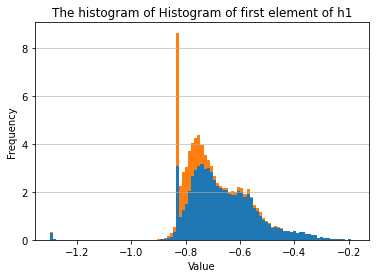

In [11]:
histogram1_w.plot(histogram1_w.data, histogram1_w.dataname, histogram1_w.bins)

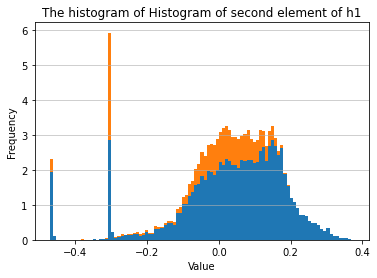

In [12]:
histogram2_w.plot(histogram2_w.data, histogram2_w.dataname, histogram2_w.bins)

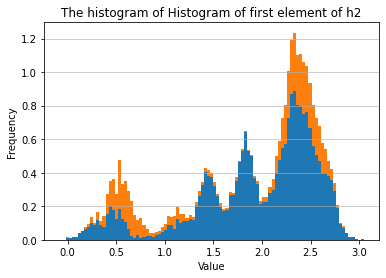

In [13]:
histogram3_w.plot(histogram3_w.data, histogram3_w.dataname, histogram3_w.bins)

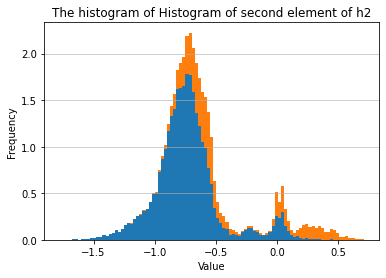

In [14]:
histogram4_w.plot(histogram4_w.data, histogram4_w.dataname, histogram4_w.bins)

In [15]:
from histogram import Histogram
histogram1 = Histogram('Histogram of first element of h1', a1, max(a1), min(a1))
histogram2 = Histogram('Histogram of second element of h1', b1, max(b1), min(b1))
histogram3 = Histogram('Histogram of first element of h2', a2, max(a2), min(a2))
histogram4 = Histogram('Histogram of second element of h2', b2, max(b2), min(b2))

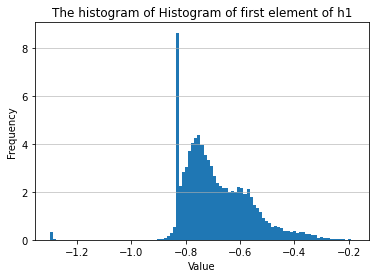

In [16]:
histogram1.plot(histogram1.data, histogram1.dataname, histogram1.bins)

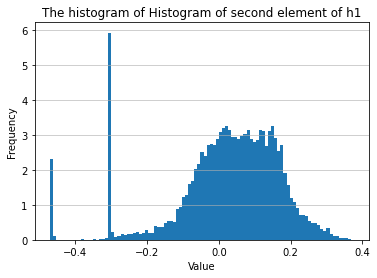

In [17]:
histogram2.plot(histogram2.data, histogram2.dataname, histogram2.bins)

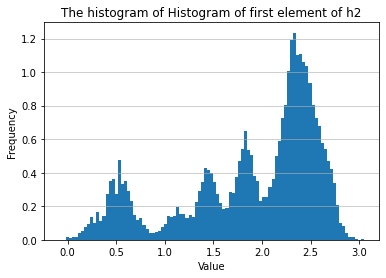

In [18]:
histogram3.plot(histogram3.data, histogram3.dataname, histogram3.bins)

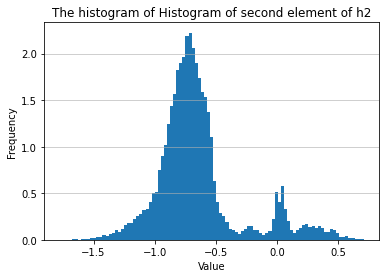

In [19]:
histogram4.plot(histogram4.data, histogram4.dataname, histogram4.bins)